In [96]:
!pip install netgraph
!pip install leidenalg
!pip install louvain

In [97]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import louvain
import numpy as np
import pandas as pd
import seaborn as sns
import igraph as ig
import leidenalg as la
from netgraph import Graph, InteractiveGraph, EditableGraph
from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram
from termcolor import colored, cprint

In [98]:
MORENO_RESIDENCE_HALL_FILE = 'networks/moreno_residence_hall.txt'

# Residence-Hall-Network

(Directed)

This directed network contains friendship ratings between 217 residents living at a residence hall located on the Australian National University campus. A node represents a person and 
an edge represents a friendship tie.  The friendships are weighted as follows from strongest to weakest tie:  5 (best friend), 4 (close friend), 3 (friend), 2, 1.

In [99]:
G = nx.read_weighted_edgelist(MORENO_RESIDENCE_HALL_FILE, create_using= nx.DiGraph, nodetype=int)
cprint(nx.info(G),'green')

DiGraph with 217 nodes and 2672 edges


In [100]:
def draw_graph(pos,nodecolors,directed=True):
    plt.figure(3, figsize=(30, 30))
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    if directed:
        nx.draw(G,node_color=nodecolors, node_size=1000,arrowsize=20, pos=pos, edgelist = edges, edge_color = weights, edge_cmap = plt.cm.Greys, edge_vmin=0.0, edge_vmax=5.0, width=.7)
    else:
        nx.draw(G,node_color=nodecolors, node_size=1000, arrowsize=0.1, pos=pos, edgelist = edges, edge_color = weights, edge_cmap = plt.cm.Greys, edge_vmin=0.0, edge_vmax=5.0, width=.7)
    nx.draw_networkx_labels(G, pos=pos, horizontalalignment='center', verticalalignment='center',font_color='white', font_weight='bold')
    ax=plt.gca()
    ax.collections[0].set_edgecolor("#000000")
    plt.show()


## Girvan–Newman
The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.

In [101]:
#Finds communities in a graph using the Girvan–Newman method.
newman_result = nx.community.girvan_newman(G)

In [102]:
# get Graph and Girvan-Newman communities list
communities = list(newman_result)

# building initial dict of node_id to each possible subset:
node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

# turning this dictionary to the desired format
node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

# also recording node_labels dict for the correct label for dendrogram leaves
node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

# also needing a subset to rank dict to later know within all k-length merges which came first
subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

# get a merge height so that it is unique
def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

# setting variable:
Gr           = nx.DiGraph(node_id_to_children)
nodes       = Gr.nodes()
leaves      = set( n for n in nodes if Gr.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if Gr.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1



### Dendogram

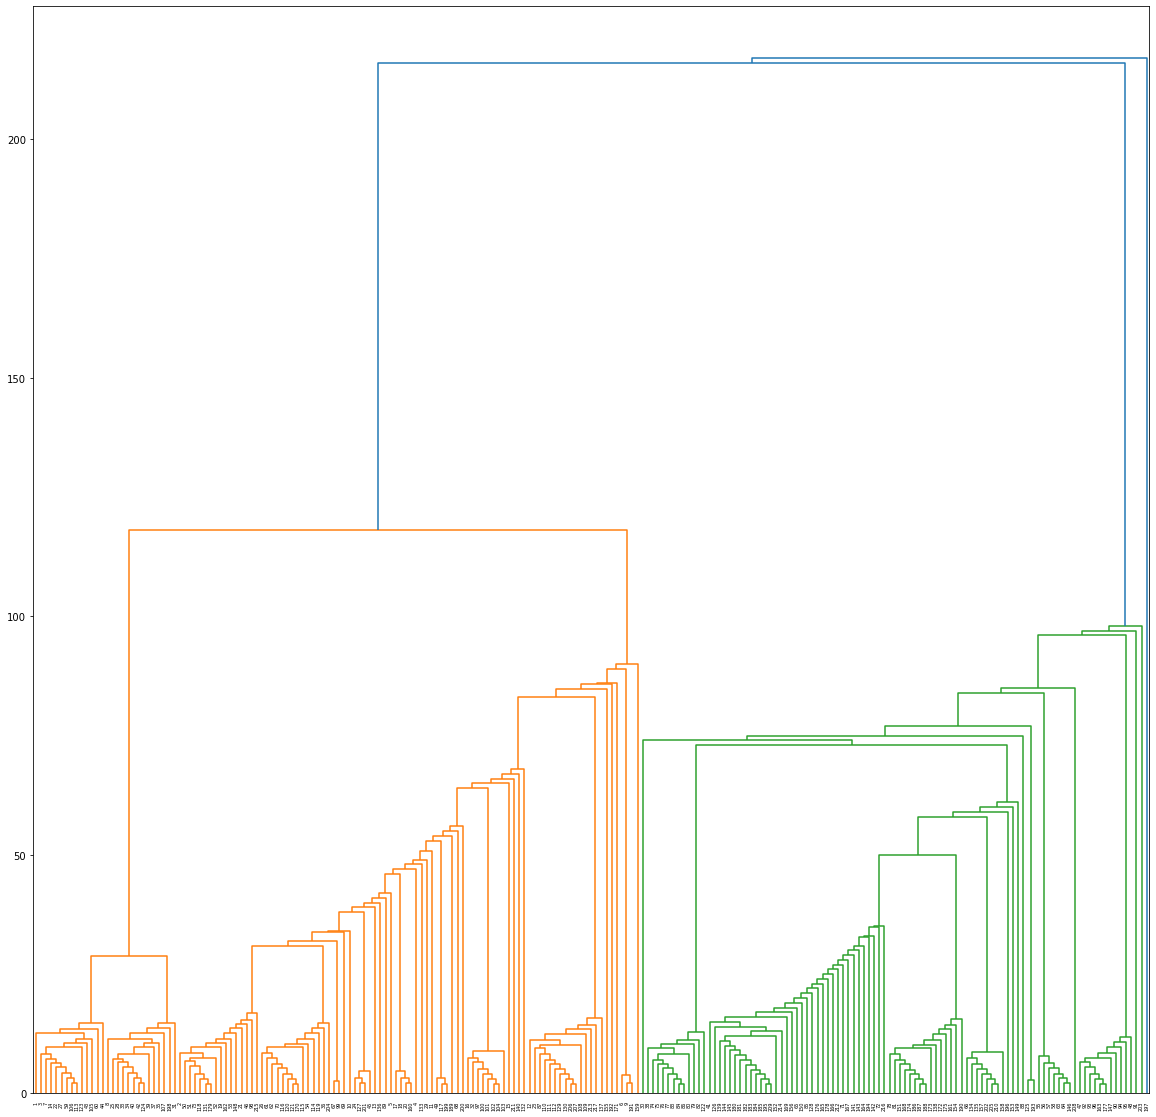

In [103]:
# dendrogram
plt.figure(4, figsize=(20, 20))
dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves],leaf_font_size=5)
plt.show()
#plt.savefig('dendrogram.png')

## Quality of partitions

### Modularity

In [104]:
newman_result = nx.community.girvan_newman(G)
newman_max_modularity = 0

modularities = []
for x in newman_result:
   modularity_of_x = nx.algorithms.community.quality.modularity(G,x, weight='weight')
   modularities.append(modularity_of_x)
   if modularity_of_x >= newman_max_modularity:
      newman_max_modularity = modularity_of_x
      best_partition = x

# print ('Values of modularity for each partition calculated:', modularities)
print('Number of iterations of Girvan Newman Algorithm:', len(modularities))
print ('Max Mmdularity:', newman_max_modularity)
#print ('Best Partition of G:', best_partition)
print('Number of community in best partition:', len(best_partition))
for idx,y in enumerate(best_partition):
   print('Community number '+ str(idx) + ' of best partition: ', y)

Number of iterations of Girvan Newman Algorithm: 216
Max Mmdularity: 0.4185044892579557
Number of community in best partition: 15
Community number 0 of best partition:  {1, 3, 7, 8, 14, 22, 25, 27, 28, 31, 33, 34, 35, 37, 39, 40, 42, 43, 44, 59, 60, 198, 105, 106, 107, 113, 123, 124}
Community number 1 of best partition:  {2, 131, 4, 5, 132, 133, 136, 10, 11, 140, 13, 15, 16, 17, 18, 19, 20, 21, 148, 24, 26, 29, 160, 32, 162, 36, 170, 45, 46, 49, 50, 51, 52, 53, 54, 179, 61, 62, 189, 67, 68, 69, 70, 199, 200, 201, 73, 204, 211, 215, 89, 97, 98, 99, 100, 101, 102, 103, 104, 114, 115, 116, 117, 118, 119, 120, 121, 127}
Community number 2 of best partition:  {9, 6, 191}
Community number 3 of best partition:  {129, 130, 137, 108, 12, 109, 110, 111, 112, 206, 207, 23, 213, 87, 217}
Community number 4 of best partition:  {30, 38, 41, 65, 66, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 122, 125, 126, 128, 134, 135, 138, 139, 141, 142, 143, 144, 145, 149, 150, 151, 152, 153

Text(0.5, 0, 'Algorithm step')

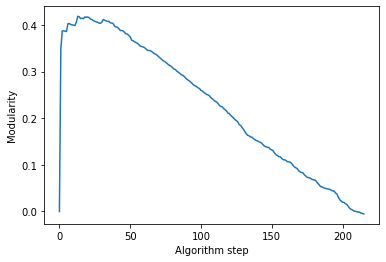

In [105]:
#The first several entries in this sequence are effectively zero while there is only one community/component, then 
#it jumps up once there is more than one community. We can use pyplot to visualize this relationship:

plt.plot(modularities)
plt.ylabel('Modularity')
plt.xlabel('Algorithm step')

In [106]:
# from tutorial of first network science book

def create_partition_map(best_partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(best_partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map  

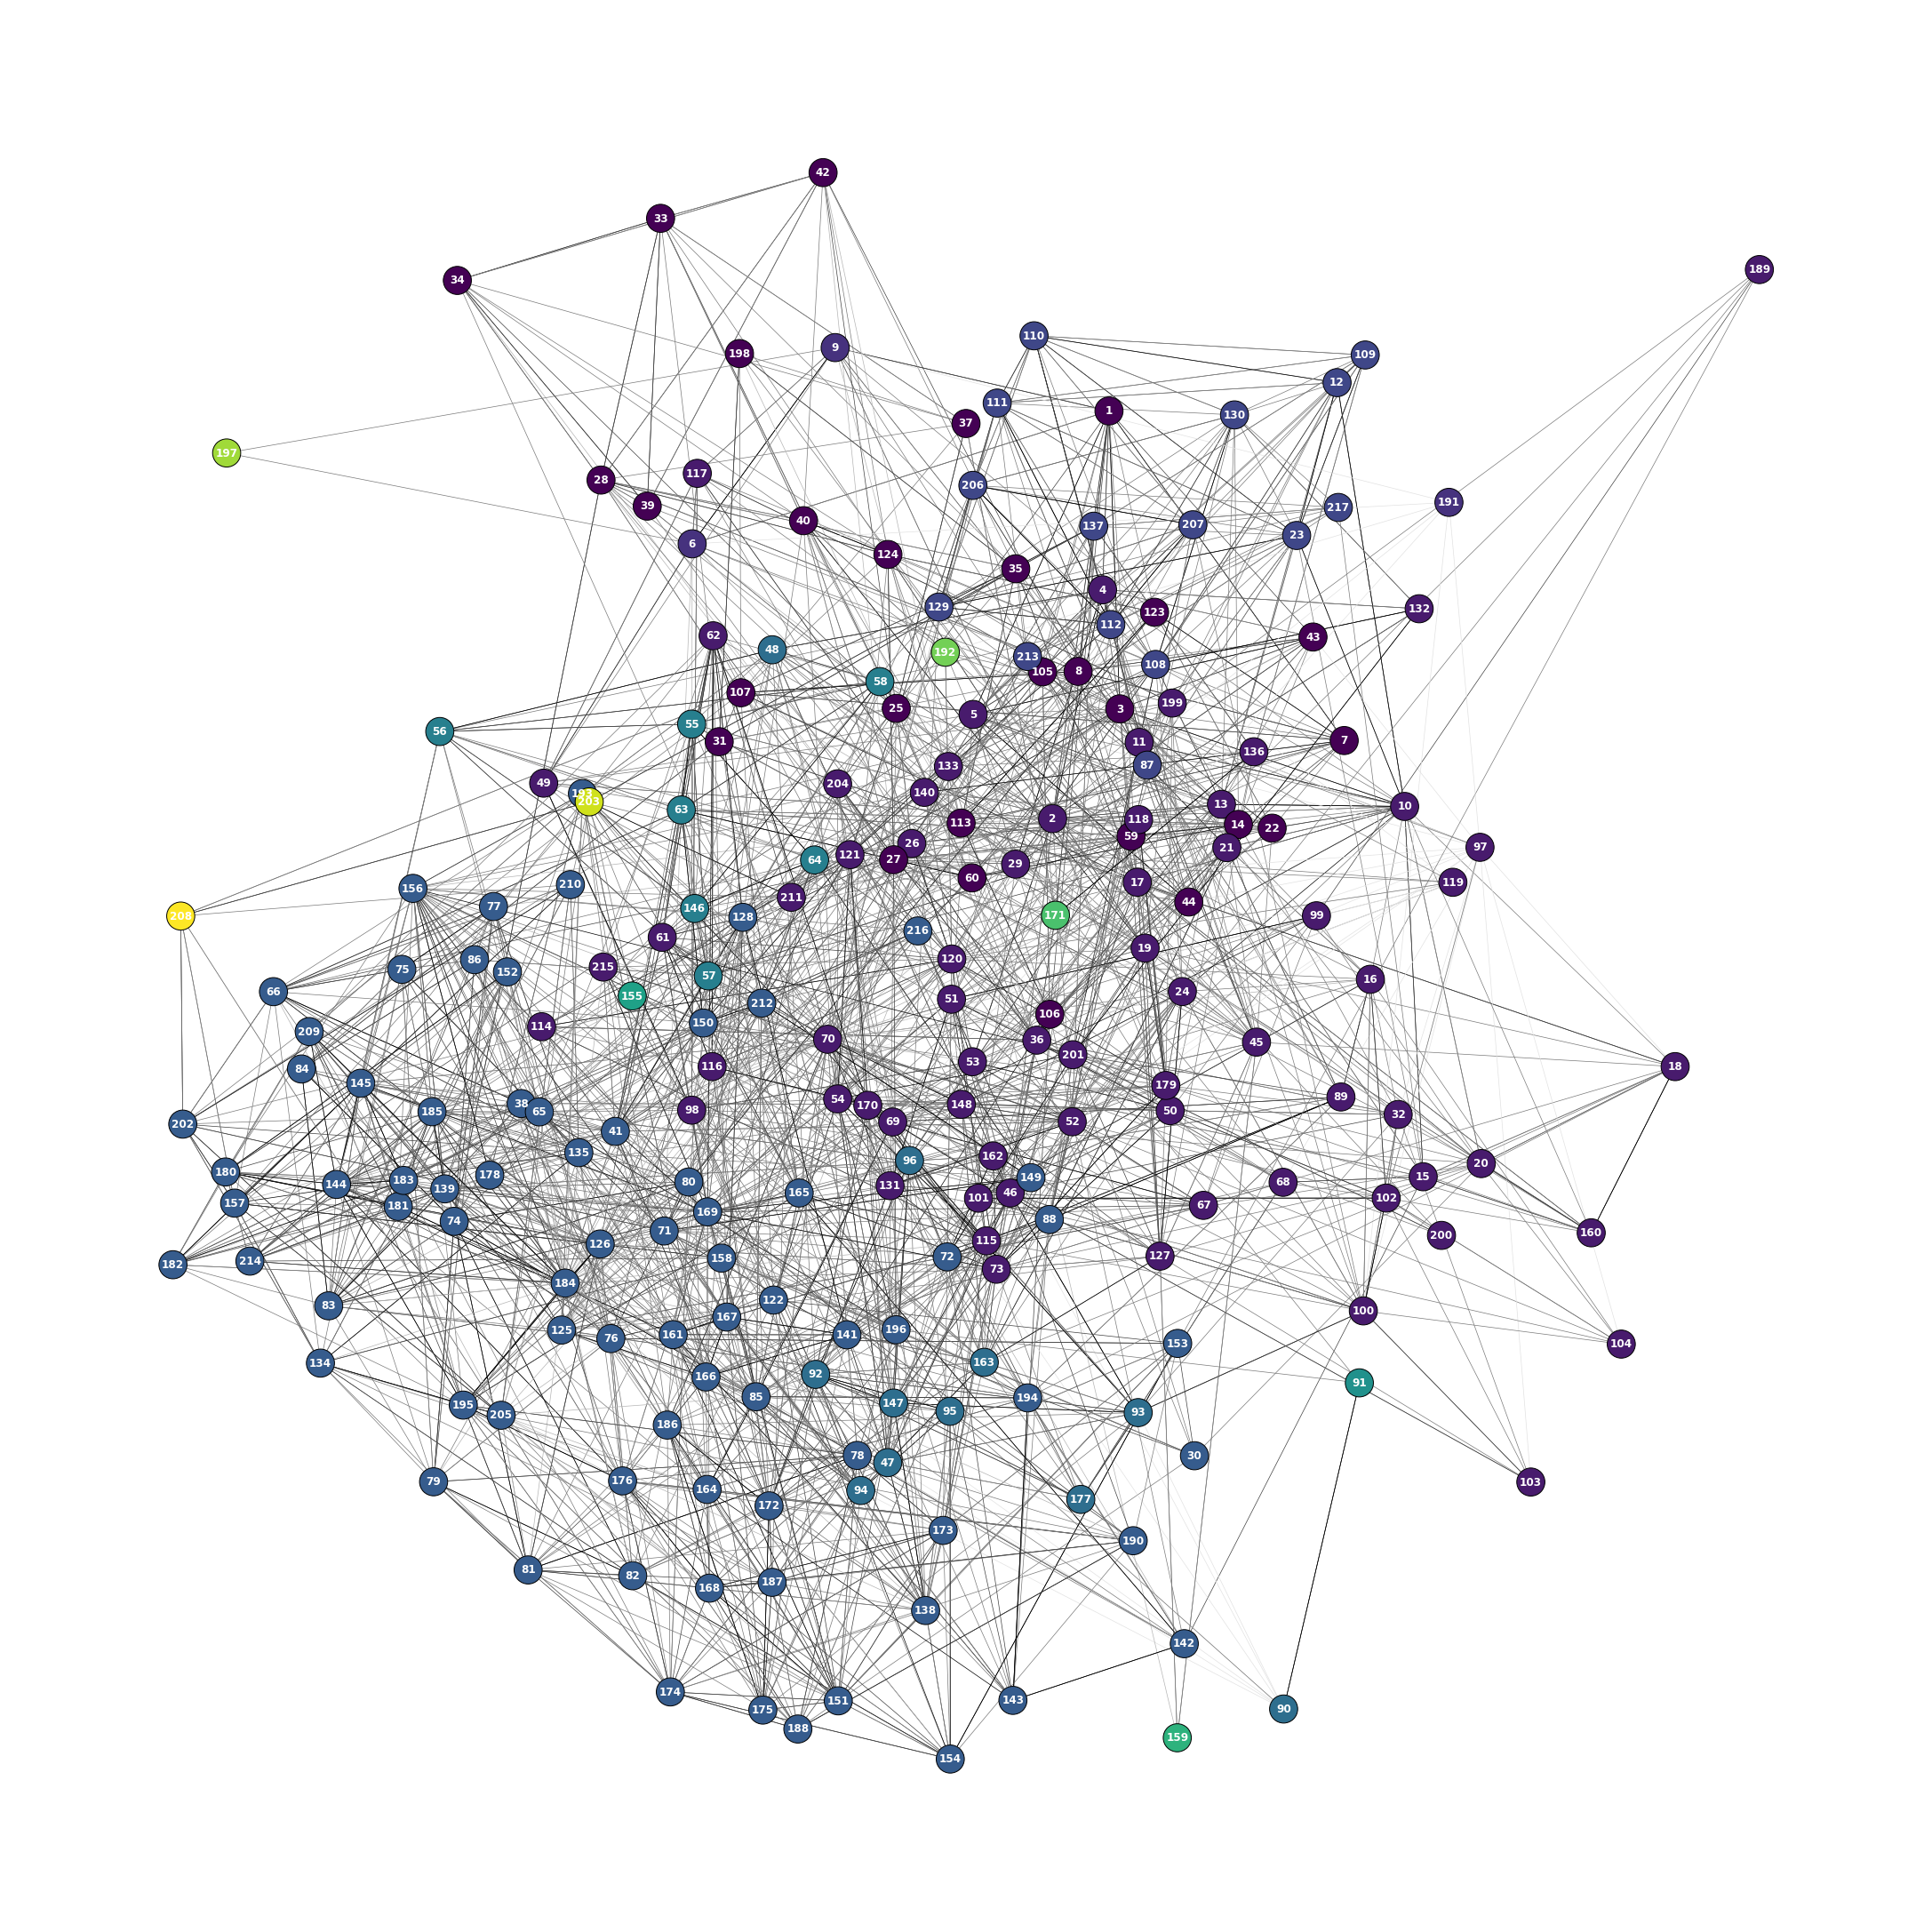

In [107]:
# from tutorial of first network science book

best_partition_map = create_partition_map(best_partition)
node_colors = [best_partition_map[n] for n in G.nodes()]
draw_graph(nx.spring_layout(G, k=0.6, iterations=50), node_colors,False)

## Louvain

In [108]:
#Transform Networkx gaph to iGraph
h = ig.Graph.from_networkx(G)

In [109]:
colors={
      0:'tab:orange',
      1:'tab:red',
      2:'tab:blue',
      3:'tab:green',
      4:'tab:cyan',
      5:'tab:purple',
      6:'tab:pink',
      7:'tab:brown',
  }

In [110]:
#set node size based on degree
node_sizes = {}
for v in h.vs:
    node_sizes[v.index] = math.log10(v.degree()+1)*5


#generate different color for each partition
def generate_partition_color(partition):
    part_colors = { }

    for idx,p in enumerate(partition):
        for n in p:
            part_colors[n]=colors[idx]
    return part_colors
  
def adapt_partition(partition):
    partition_transf={}
    for idx,p in enumerate(partition):
        for y in p:
            partition_transf[y]=idx
    return partition_transf

In [121]:
partition_louvain = louvain.find_partition(h, louvain.ModularityVertexPartition, weights='weight')

C:\Users\Daniele\anaconda3\lib\site-packages\netgraph\_edge_layout.py:639: RuntimeWarning: invalid value encountered in true_divide
  displacement = compatibility * delta / distance_squared[..., None]


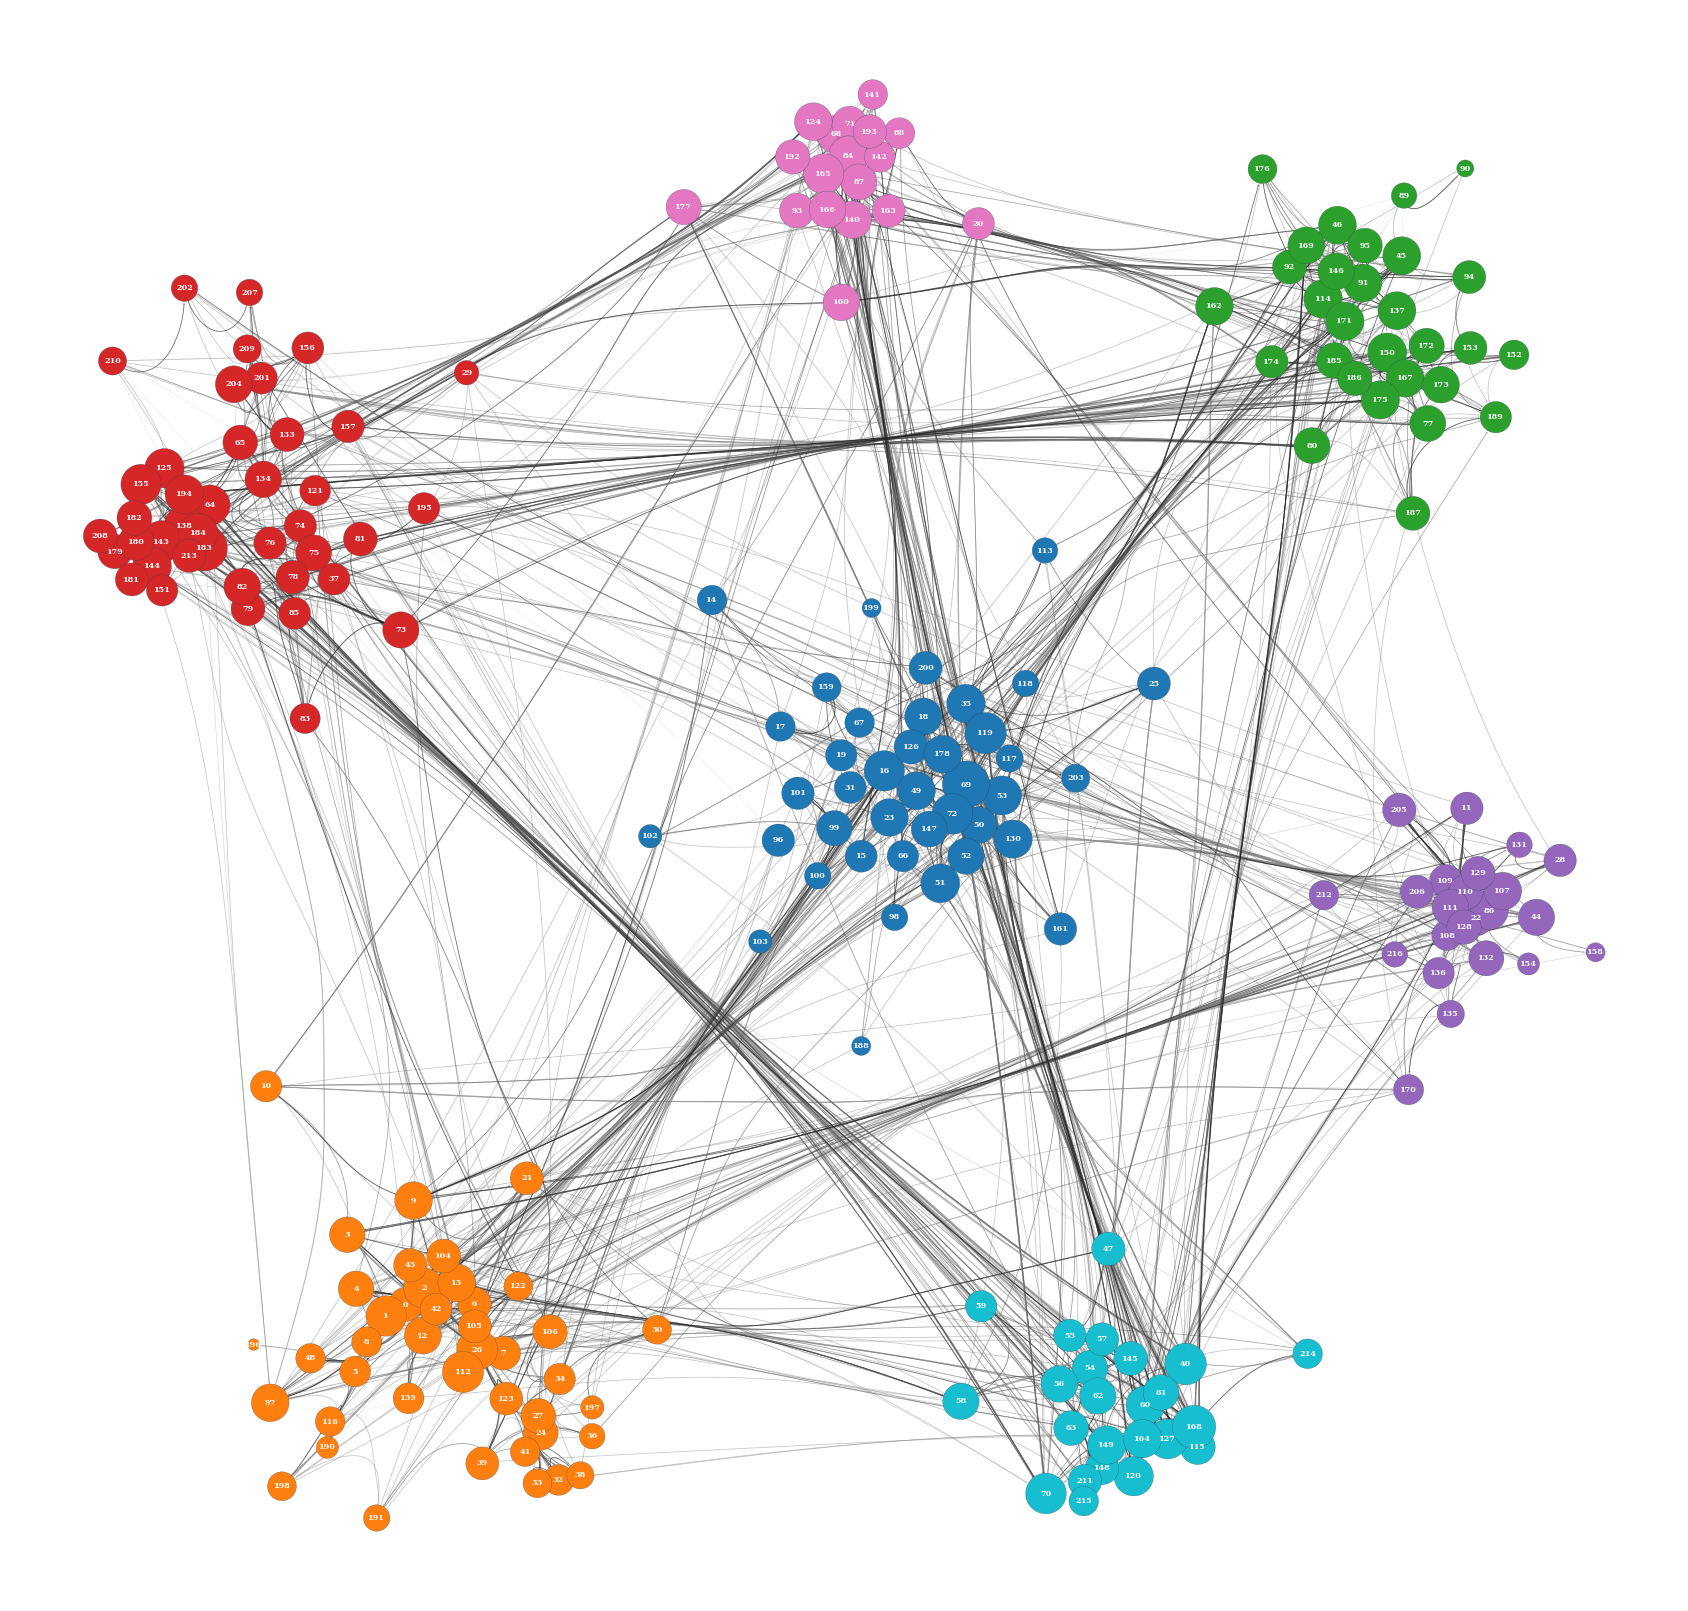

In [112]:
plt.figure(7, figsize=(30, 30))
plot_instance = Graph(h,
                        node_size=node_sizes,
                        node_edge_width=0.1,
                        edge_width=0.3,
                        node_labels=True,
                        node_label_fontdict= {'family': 'serif','color':'white','weight': 'bold','size': 8},
                        node_layout='community',
                        arrows=True,
                        edge_layout='bundled',
                        node_layout_kwargs=dict(node_to_community=adapt_partition(partition_louvain)),
                        node_color=generate_partition_color(partition_louvain),
                        scale=(5,5))
plt.show()

In [124]:
print(partition_louvain)
print(newman_result)

Clustering with 217 elements and 7 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16, 21, 24, 26, 27, 28, 30, 32,
    33, 34, 36, 38, 39, 41, 42, 43, 44, 48, 58, 97, 104, 105, 106, 112, 116,
    122, 123, 139, 158, 190, 191, 196, 197, 198
[1] 29, 37, 65, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 121, 133, 134,
    137, 150, 152, 153, 156, 157, 167, 171, 172, 173, 174, 175, 185, 186, 187,
    189, 195, 201, 202, 204, 207, 209, 210
[2] 14, 15, 17, 18, 19, 20, 23, 31, 49, 50, 51, 52, 53, 66, 67, 68, 69, 71,
    72, 87, 88, 96, 98, 99, 100, 101, 102, 103, 117, 126, 130, 147, 159, 161,
    162, 178, 188, 199, 200, 214
[3] 40, 64, 70, 84, 93, 124, 125, 127, 138, 140, 141, 142, 143, 144, 148, 149,
    151, 155, 160, 163, 164, 165, 166, 168, 177, 179, 180, 181, 182, 183, 184,
    192, 193, 194, 208, 211, 213, 215
[4] 25, 35, 45, 46, 89, 90, 91, 92, 94, 95, 113, 114, 115, 118, 119, 120, 146,
    169, 176, 203
[5] 11, 22, 86, 107, 108, 109, 110, 111, 128, 129, 131, 132, 135, 136, 1

## Leiden

In [117]:
partition_leiden = la.find_partition(h, la.ModularityVertexPartition,  weights='weight')        
        
#print(partition_leiden)        

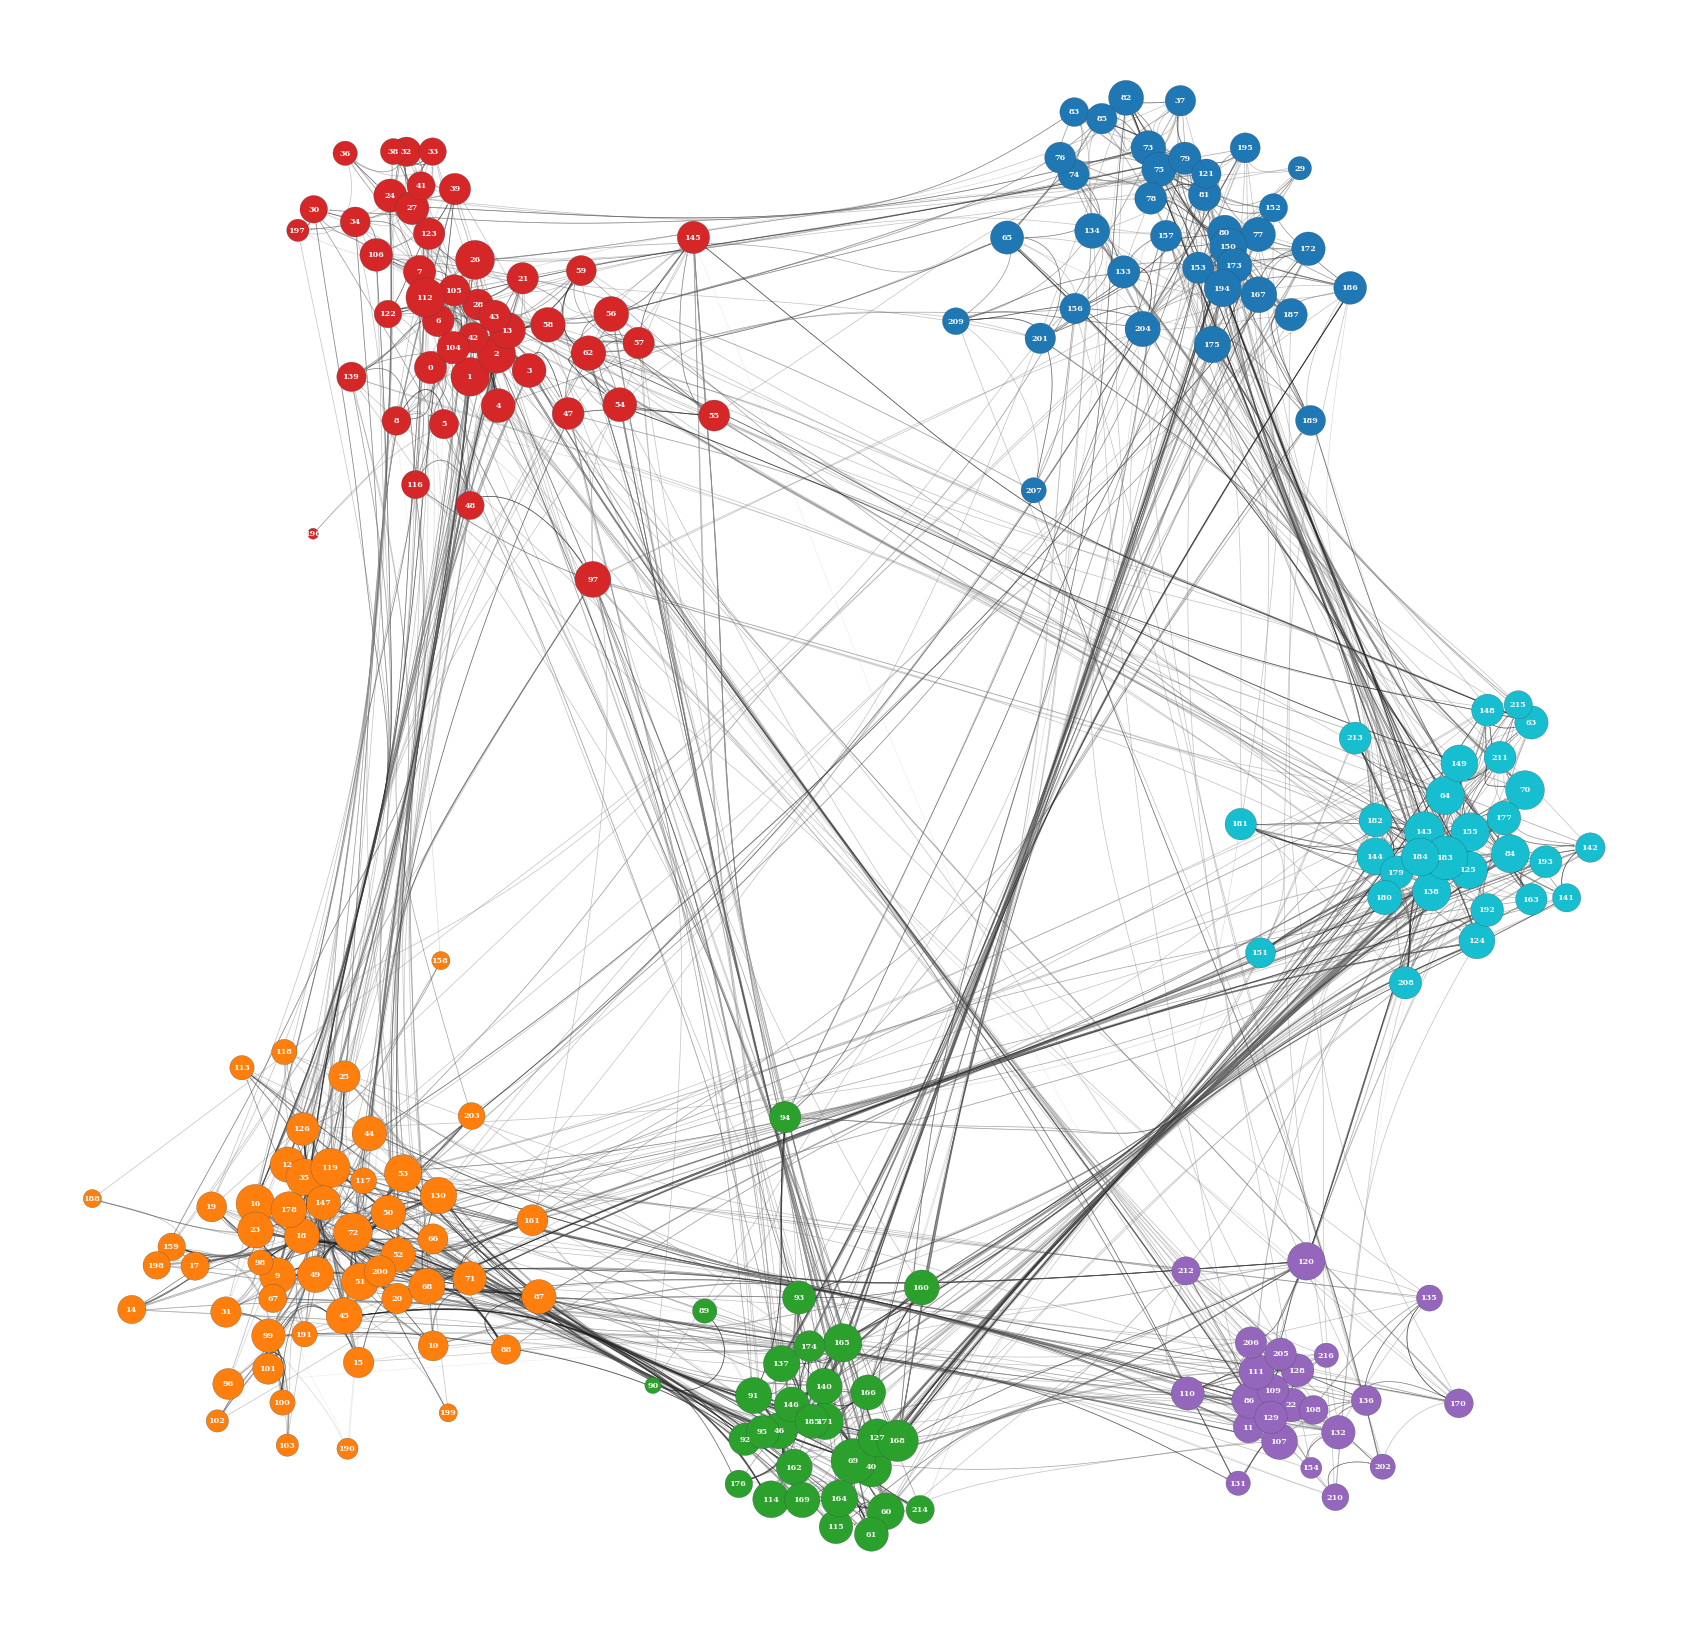

In [ ]:
# Create a non-interactive plot:
plt.figure(8, figsize=(30, 30))
plot_instance = Graph(h,
                    node_size=node_sizes,
                    node_edge_width=0.1,
                    edge_width=0.3,
                    node_labels=True,
                    node_label_fontdict= {'family': 'serif','color':'white','weight': 'bold','size': 8},
                    node_layout='community',
                    arrows=True,
                    edge_layout='bundled',
                    node_layout_kwargs=dict(node_to_community=adapt_partition(partition_leiden)),
                    node_color=generate_partition_color(partition_leiden),
                    scale=(5,5))
plt.show()

#,edge_layout='curved'
#from netgraph import Graph; help(Graph)

# Modularity comparison

In [ ]:
modularity_louvain = h.modularity(partition_louvain, weights='weight')
modularity_leiden = h.modularity(partition_leiden, weights='weight')

In [ ]:
cprint('Girvan-Newman modularity:', 'blue', end=' ') 
cprint(round(newman_max_modularity,3), 'green')
cprint('Louvain modularity:', 'blue', end=' ') 
cprint(round(modularity_louvain,3), 'green')
cprint('Leiden modularity:', 'blue', end=' ') 
cprint(round(modularity_leiden,3), 'green')

Girvan-Newman modularity: 0.419
Louvain modularity: 0.486
Leiden modularity: 0.494


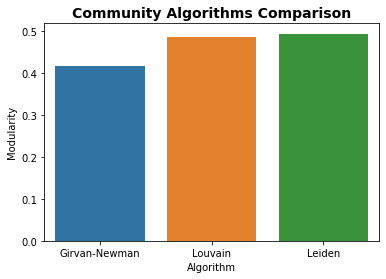

In [ ]:
newman_data = pd.DataFrame({'Algorithm':'Girvan-Newman', 'Modularity' : [newman_max_modularity]})
louvain_data = pd.DataFrame({'Algorithm':'Louvain', 'Modularity' : [modularity_louvain]})
leiden_data = pd.DataFrame({'Algorithm':'Leiden', 'Modularity' : [modularity_leiden]})

modularity_data = pd.concat([newman_data,louvain_data,leiden_data])


#plotting graph
sns.barplot(
    data=modularity_data,
    x='Algorithm', y='Modularity'
    
)

plt.title('Community Algorithms Comparison',fontdict= { 'fontsize': 14, 'fontweight':'bold'})
plt.show()